In [1]:
import dgl
import torch
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pacmap

sys.path.append('../src')

from HGMAE import HGMAE
from utils import normalize_features

sns.set_style('white')
mpl.rcParams['font.family'] = 'Times New Roman'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Demonstration of learned embeddings on a toy graph (IMDB)

In [2]:
HG = dgl.load_graphs("../toy_graphs/imdb.bin")[0][0]
edge_type_mapping = {can_etype[1]: (can_etype[0], can_etype[2]) for can_etype in HG.canonical_etypes}
in_dim = {ntype: HG.nodes[ntype].data['feat'].shape[1] for ntype in HG.ntypes}
out_dim = {ntype: 128 for ntype in HG.ntypes}
hidden_dim = {ntype: 128 for ntype in HG.ntypes}
ntypes = HG.ntypes
etypes = HG.etypes
features = {ntype: HG.nodes[ntype].data['feat'] for ntype in HG.ntypes}

model = HGMAE(
    n_layers=2,
    n_heads=4,
    in_dim=in_dim,
    out_dim=out_dim,
    hidden_dim=hidden_dim,
    n_out_heads=1,
    node_type_list=ntypes,
    edge_type_list=etypes,
    edge_type_mapping=edge_type_mapping,
    leave_unchanged=0.25,
    replace_rate=0.1,
    temporal=False,
)
model_path = '../models/HGTMAE_toy_run-11-08-16-15/checkpoint_29.pth'
state_dict = torch.load(model_path)
model.load_state_dict(state_dict, strict=False)
model.eval()

HGMAE(
  (GNN_encoder): HGT(
    (layers): ModuleList(
      (0-1): 2 x HGTLayer(
        (QueryVectors): ModuleDict(
          (actor): Linear(in_features=128, out_features=128, bias=False)
          (director): Linear(in_features=128, out_features=128, bias=False)
          (movie): Linear(in_features=128, out_features=128, bias=False)
        )
        (KeyVectors): ModuleDict(
          (actor): Linear(in_features=128, out_features=128, bias=False)
          (director): Linear(in_features=128, out_features=128, bias=False)
          (movie): Linear(in_features=128, out_features=128, bias=False)
        )
        (MLinears): ModuleDict(
          (actor): Linear(in_features=128, out_features=128, bias=False)
          (director): Linear(in_features=128, out_features=128, bias=False)
          (movie): Linear(in_features=128, out_features=128, bias=False)
        )
        (ALinears): ModuleDict(
          (actor): Linear(in_features=128, out_features=128, bias=False)
          (dire

In [3]:
def process_full_graph(graph, features, model):
    with torch.no_grad():
        features = {ntype: normalize_features(feat) for ntype, feat in features.items()}
        embeddigns = model.get_embeddings(graph, features)
    return embeddigns

In [4]:
embeddings = process_full_graph(HG, features, model)
A_embeddings = embeddings['actor']
D_embeddings = embeddings['director']
M_embeddings = embeddings['movie']

In [5]:
A_embeddings = pacmap.PaCMAP(n_components=2).fit_transform(A_embeddings)
D_embeddings = pacmap.PaCMAP(n_components=2).fit_transform(D_embeddings)
M_embeddings = pacmap.PaCMAP(n_components=2).fit_transform(M_embeddings)

In [6]:
movie_genres = torch.load('../toy_graphs/imdb_labels.pt')

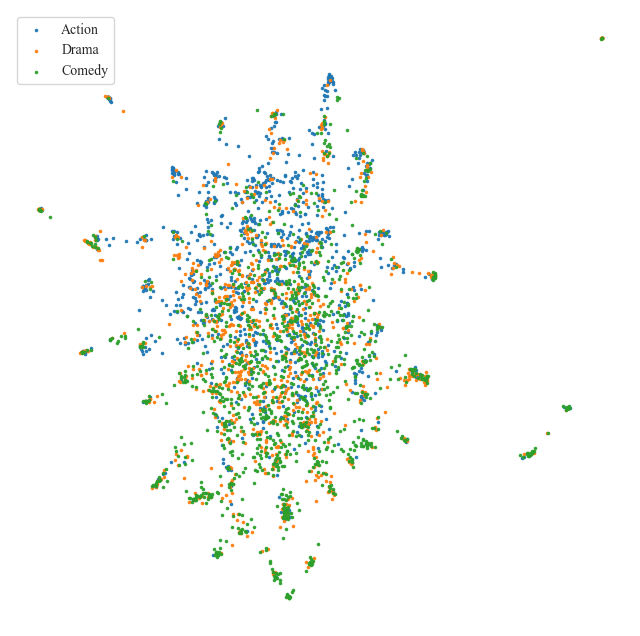

In [7]:

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for genre in set(movie_genres):
    idx = [i for i, g in enumerate(movie_genres) if g == genre]
    ax.scatter(M_embeddings[idx, 0], M_embeddings[idx, 1], label=genre, s=10, marker='.', alpha=0.9)
ax.legend()
ax.axis('off')
plt.show()